In [1]:
import keras
from keras import layers
import tensorflow as tf
import numpy as np
import cv2

classNames=["Inflammatory","Normal","Polypoid","Vascular"]

img_height,img_width=256,256 
data_dir=".\Anomaly"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=1)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=1)


train_x=[]
train_y=[]
test_x=[]
test_y=[]
for image, label in train_ds:
    train_x.append(image.numpy()[0])
    train_y.append(label.numpy()[0])
for image, label in val_ds:
    test_x.append(image.numpy()[0])
    test_y.append(label.numpy()[0])


Found 1720 files belonging to 4 classes.
Using 1376 files for training.
Found 1720 files belonging to 4 classes.
Using 344 files for validation.


In [11]:
import pandas as pd
pd.DataFrame({'y':test_y})['y'].value_counts()

1    356
3     81
0     61
2     18
Name: y, dtype: int64

In [2]:
input_img = keras.Input(shape=(4*256,))
x = layers.Dense(64,activation="tanh")(input_img)
x = layers.Dense(4,activation="softmax")(x)
testModel = keras.Model(input_img, x, name="test")
testModel.summary()

Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 65,860
Trainable params: 65,860
Non-trainable params: 0
_________________________________________________________________


In [2]:


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp( z_log_var) * epsilon

latent_dim=256
input_img = keras.Input(shape=(256, 256, 3))
x = layers.Conv2D(3, (3, 3), activation='tanh', padding='same')(input_img)
x=layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
x = layers.MaxPooling2D((8, 8), padding='same')(x)
x = layers.Flatten()(x)
x=layers.BatchNormalization()(x)
z_mean = layers.Dense(latent_dim, name="z_mean",activation="tanh")(x)
z_mean=layers.BatchNormalization()(z_mean)
z_log_var = layers.Dense(latent_dim, name="z_log_var",activation="tanh")(x)
z_log_var=layers.BatchNormalization()(z_log_var)
encoded = Sampling()([z_mean, z_log_var])
encoder = keras.Model(input_img, [z_mean, z_log_var, encoded], name="encoder")
print(encoded.shape)



latent_inputs_classifier = keras.Input(shape=(latent_dim,))
x = layers.Dense(16)(latent_inputs_classifier)
classifierOutput = layers.Dense(4,activation='softmax')(latent_inputs_classifier)
classifier = keras.Model(latent_inputs_classifier, classifierOutput, name="classifier")

latent_inputs1 = keras.Input(shape=(latent_dim,))
latent_inputs2 = keras.Input(shape=(latent_dim,))
def eq_distance(A,B):
   return tf.math.reduce_sum(keras.backend.sqrt(keras.backend.sum(keras.backend.square(A - B))))
merged_vector = layers.Lambda(lambda x: eq_distance(x[0],x[1]))([latent_inputs1,latent_inputs2])
distanceModel = keras.Model([latent_inputs1,latent_inputs2], merged_vector, name="distance")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Reshape((16, 16,1))(latent_inputs)
x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
x=layers.BatchNormalization()(x)
x = layers.UpSampling2D((4, 4))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded=layers.BatchNormalization()(decoded)
print("decoded")
print(decoded.shape)
decoder = keras.Model(latent_inputs, decoded, name="decoder")


(None, 256)
decoded
(None, 256, 256, 3)


In [4]:

class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    

class VAE(keras.Model):
    def __init__(self, encoder, decoder,distance,classifier, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
        self.distance= distance
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.distance_loss_tracker = keras.metrics.Mean(name="distance")
        # self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.classifier_loss=keras.metrics.Mean(name="classifier_loss")
        self.classifier_metrics = keras.metrics.AUC()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.distance_loss_tracker,
            # self.kl_loss_tracker,
            self.classifier_loss,
            self.classifier_metrics
        ]

    def train_step(self, dataAndTarget):
        data, target = dataAndTarget
        data, self.trainDataOther=data
        target, targetOther=target
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data,training=True)
           
            z_meanOther, z_log_varOther, zOther = self.encoder(self.trainDataOther,training=False)

            distance_loss=self.distance([z_meanOther,z_mean],training=False)
        
            reconstruction = self.decoder(z,training=True)
            predictedClass = self.classifier(z_mean)
            predictedClassOther = self.classifier(z_meanOther)
            # reconstruction_loss = -1*tf.image.psnr(data, reconstruction, max_val=1.0)
           
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction), axis=(1, 2)
                )
            )
           
            classifier_loss=tf.reduce_sum(
                    keras.losses.categorical_crossentropy( tf.concat((target, targetOther), axis=0),  tf.concat((predictedClass, predictedClassOther), axis=0))
                )
            # kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = classifier_loss*reconstruction_loss/(10*distance_loss)
            grads = tape.gradient(total_loss, self.trainable_weights)  
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.distance_loss_tracker.update_state(distance_loss)
        # self.kl_loss_tracker.update_state(kl_loss)
        self.classifier_metrics.update_state(target,predictedClass)
        
        

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "distance_loss":self.distance_loss_tracker.result(),
            # "kl_loss": self.kl_loss_tracker.result(),
            "AUC": self.classifier_metrics.result()
        }


In [5]:
from keras.utils import to_categorical
from sklearn.metrics import classification_report

batch_size=32

train_y=np.asarray(train_y)
indexClass=train_y==0
trainData=np.asarray(train_x).astype("float32")[indexClass]/255
targetData=to_categorical(np.asarray(train_y))[indexClass,:]

indexClassOthers=train_y!=0
trainDataOther=np.asarray(train_x).astype("float32")[indexClass]/255
targetDataOther=to_categorical(np.asarray(train_y))[indexClass,:]


vae = VAE(encoder, decoder,distanceModel,classifier)
vae.compile(optimizer=keras.optimizers.Adam())
history=vae.fit([trainData,trainDataOther] ,[targetData,targetDataOther], epochs=3, batch_size=batch_size)


Epoch 1/3
6/6 [==============================] - 13s 2s/step - loss: 11651.3571 - reconstruction_loss: 74719.4141 - distance_loss: 104.8374 - AUC: 0.6093
Epoch 2/3
6/6 [==============================] - 11s 2s/step - loss: 10511.3848 - reconstruction_loss: 71928.2422 - distance_loss: 127.3615 - AUC: 0.6858
Epoch 3/3
6/6 [==============================] - 11s 2s/step - loss: 9198.2863 - reconstruction_loss: 68673.7188 - distance_loss: 128.6777 - AUC: 0.6845


In [ ]:
allTarget=np.concatenate([train_y, test_y], axis=0)
allData = np.concatenate([train_x, test_x], axis=0)
allData = allData.astype("float32") / 255
z_mean, _, _ = vae.encoder.predict(allData)
testOut=vae.classifier.predict(z_mean)
print(classification_report(allTarget, np.argmax(testOut,axis=1)))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

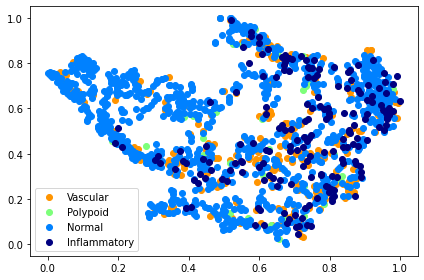

In [57]:
from sklearn.manifold import TSNE
import matplotlib.pylab as plt
from umap import UMAP
umap_2d = UMAP(n_components=2, init='random')
umap_3d = UMAP(n_components=3, init='random')
cmap = plt.cm.get_cmap('jet')
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

def plot_in_group(tx,ty,targetTrain):
    fig = plt.figure()
    # ax = fig.add_subplot(111,projection='3d')
    ax = fig.add_subplot(111)
    for i in range(3,-1,-1):
        txG=tx[targetTrain==i]
        tyG=ty[targetTrain==i]
        # tzG=tz[targetTrain==i]
        targetTrainG=targetTrain[targetTrain==i]
        ax.scatter(txG, tyG, c=cmap(i/4),label=classNames[i])
    plt.tight_layout()
    plt.legend()
    fig.savefig('tsne_targetClass.png', dpi=100)

# display a 2D plot of the digit classes in the latent space
dataTrain=np.asarray(train_x)
targetTrain=np.asarray(train_y)
z_mean, _, _ = vae.encoder.predict(dataTrain)
# print(z_mean)
tsne = TSNE(n_components=2,perplexity=40).fit_transform(z_mean)
# tsne = umap_2d.fit_transform(z_mean)
tx = tsne[:, 0]
ty = tsne[:, 1]
# tz = tsne[:, 2]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
# tz = scale_to_01_range(tz)
plot_in_group(tx,ty,targetTrain)

No handles with labels found to put in legend.


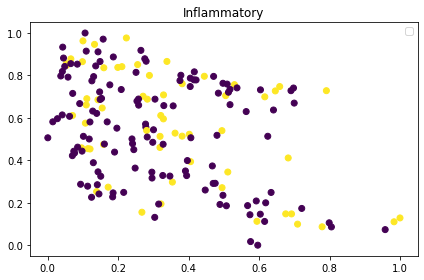

In [47]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.svm import OneClassSVM


def plot_in_group_for_cluster(tx,ty,labels,targetTrain,i):
    fig2 = plt.figure()
    # ax = fig.add_subplot(111,projection='3d')
    firstSubPlot=111
    ax2 = fig2.add_subplot(firstSubPlot)
    # ax2.scatter(tx, ty,marker='+')
    txG=tx[targetTrain==i]
    tyG=ty
    labelsG=labels
    ax2.scatter(txG, tyG, c=labelsG)
    ax2.set_title('{}'.format(classNames[i]))
    ax2.legend()
    # produce a legend with a cross section of sizes from the scatter
    firstSubPlot=firstSubPlot+1
    plt.tight_layout()
    
    fig2.savefig('tsne_cluster.png', dpi=100)

txAll=[]
tyAll=[]
labelsAll=[]
targetTrainTemp=[]
clf=[]
i=0
dataClass=z_mean
# OCC
# clf.append(OneClassSVM(gamma='auto').fit(dataClass))

dataClassLabels=targetTrain[targetTrain==i]
tsneDataClass = tsne[targetTrain==i]
clust = OPTICS(min_samples=7,p=1, xi=.01, min_cluster_size=.2)
clust.fit(dataClass[targetTrain==i])
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]
labels=labels - np.min(labels)
if len(labelsAll)>0:
    biasLabel=np.max(labelsAll)
else:
    biasLabel=0
labelsAll.extend(labels+biasLabel)
tx = tsneDataClass[:, 0]
ty = tsneDataClass[:, 1]
# tz = tsne[:, 2]
targetTrainTemp.extend(np.zeros([tx.shape[0],1])[:,0]+i)
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
txAll.extend(tx)
tyAll.extend(ty)
plot_in_group_for_cluster(np.asarray(txAll), np.asarray(tyAll), np.asarray(labelsAll),np.asarray(targetTrainTemp),i)




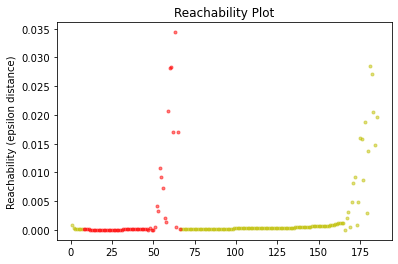

In [49]:
# Reachability plot
fig2 = plt.figure()
firstSubPlot=111
ax3 = fig2.add_subplot(firstSubPlot)
space = np.arange(tx.shape[0])
colors = ['y.', 'r.', 'y.', 'b.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    try:
        Rk[-20:-1:1]=np.random.rand(19)*np.linspace(0,0.04,19)
    except:
        pass
    ax3.plot(Xk,Rk, color, alpha=0.5)
ax3.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
# ax3.plot(space, np.full_like(space, 3., dtype=float), 'k-', alpha=0.5)
# ax3.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax3.set_ylabel('Reachability (epsilon distance)')
ax3.set_title('Reachability Plot')
fig2.savefig('reachilibity.png', dpi=100)

array([], dtype=float64)

In [199]:

import xgboost as xgb
param = {'eval_metric':'auc','num_class':4}  # the number of classes that exist in this datset
dataTrain=np.asarray(train_x)
targetTrain=np.asarray(train_y)
z_mean, _, _ = vae.encoder.predict(dataTrain)
output=[]
for model in clf:
    output.append(model.predict(z_mean))
output=np.asarray(output).transpose()
output=np.append(z_mean,output,axis=1)
dtrain = xgb.DMatrix(output, label=targetTrain.transpose())
bst = xgb.train(param,dtrain)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

(1376, 260)

In [126]:
from sklearn.metrics import classification_report

dataTest=np.asarray(test_x)
targetTest=np.asarray(test_y)
_, z_mean, _ = vae.encoder.predict(dataTest)
output=[]
for model in clf:
    output.append(model.predict(z_mean))
output=np.asarray(output).transpose()
output=np.append(z_mean,output,axis=1)
output = xgb.DMatrix(output)
testOut=bst.predict(output)
print(classification_report(targetTest, testOut))
           

              precision    recall  f1-score   support

           0       0.27      0.11      0.16        61
           1       0.74      0.90      0.81       356
           2       0.00      0.00      0.00        18
           3       0.33      0.21      0.26        81

    accuracy                           0.67       516
   macro avg       0.33      0.31      0.31       516
weighted avg       0.59      0.67      0.62       516



In [53]:
testOut

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

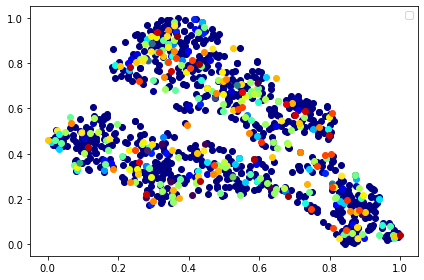

In [40]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.cm as cm

def plot_in_group(tx,ty,labels):
    fig3 = plt.figure()
    # ax = fig.add_subplot(111,projection='3d')
    ax3 = fig3.add_subplot(111)
    classNumbers=len(np.unique(labels))
    for i in range(classNumbers):
        txG=tx[labels==i]
        tyG=ty[labels==i]
        ax3.scatter(txG, tyG, c=cmap(i/classNumbers))
    plt.tight_layout()
    plt.legend()
    fig3.savefig('tsne_opticsonAllClass.png', dpi=100)

txAll=[]
tyAll=[]
labelsAll=[]

dataClass=z_mean
dataClassLabels=targetTrain
clust = OPTICS(min_samples=5,p=2, xi=.001, min_cluster_size=.001)
clust.fit(dataClass)
reachability = clust.reachability_[clust.ordering_]
labelsAll = clust.labels_[clust.ordering_]

tsneDataClass = tsne
tx = tsneDataClass[:, 0]
ty = tsneDataClass[:, 1]
# tz = tsne[:, 2]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
txAll.extend(tx)
tyAll.extend(ty)
labelsAll=labelsAll+1
plot_in_group(np.asarray(txAll), np.asarray(tyAll), np.asarray(labelsAll))

In [184]:
np.unique(labelsAll)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

dict_keys(['loss', 'reconstruction_loss', 'distance_loss', 'AUC'])


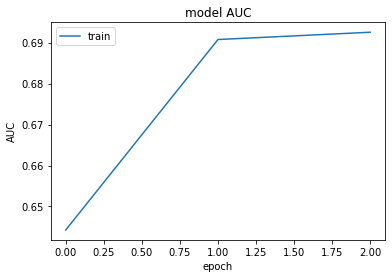

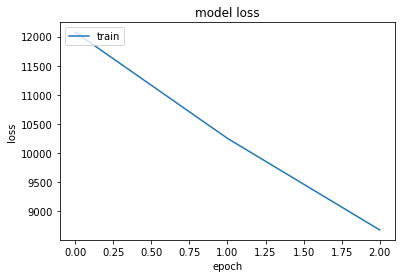

In [56]:
print(history.history.keys())
# summarize history for accuracy

plt.plot(history.history['AUC'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['kl_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()